In [1]:
import csv, sys
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np; np.set_printoptions(threshold=sys.maxsize)

TOTAL_ROWS= 2228278
INPUT_ROWS_LIMIT= TOTAL_ROWS # TOTAL_ROWS
FILENAME= 'dublinbikes_2020_Q1.csv'
MAX_STATION_ID= 117
SECS_IN_5MIN= 300
DATAPOINTS_PER_DAY= 288
DAYS_OF_WEEK= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # yes, I consider Monday to be the '0'/start of the week
STARTING_DAY= 4
MISSING_STATIONS= [117, 116, 70, 60, 46, 35, 20, 14, 1]
TOTAL_DAYS= 91
MAX_DISPLAYED_STATIONS= 1
MAX_DISPLAYED_DAYS= 10
MAX_TIME= int((datetime.datetime(2020,4,2,0,0) - datetime.datetime(2020,1,1,0,0)).total_seconds() / SECS_IN_5MIN)

class DataDay: # ideally this would be nested in the Station class
    def __init__(self, index):
        self.index= index
        self.day_of_week= -1
        self.day_since_epoch= -1
        self.daily_epoch_time= np.zeros(shape= DATAPOINTS_PER_DAY)
        self.epoch_time= np.zeros(shape= DATAPOINTS_PER_DAY)
        self.percent_bikes= np.zeros(shape= DATAPOINTS_PER_DAY)

    def populate(self, daily_epoch_time, epoch_time, percent_bikes):
        self.day_of_week= (STARTING_DAY + int(epoch_time / DATAPOINTS_PER_DAY)) % len(DAYS_OF_WEEK)
        self.day_since_epoch= 1 + int(epoch_time / DATAPOINTS_PER_DAY)
        self.daily_epoch_time[daily_epoch_time]= daily_epoch_time
        self.epoch_time[daily_epoch_time]= epoch_time
        self.percent_bikes[daily_epoch_time]= percent_bikes

class Station:
    def __init__(self, index):
        self.index= index
        self.name= -1
        self.bike_capacity= -1 # populating with -1 initially as a debugging means
        self.address= -1
        self.latitude= -1
        self.longitude= -1
        self.data_days= [DataDay(i) for i in range(1, TOTAL_DAYS + 3)] # Admitedly, I don't even know exactly why this has to be +3
    
    def populate_consts(self, name, bike_capacity, address, latitude, longitude):
        self.name= name
        self.bike_capacity= bike_capacity
        self.address= address
        self.latitude= latitude
        self.longitude= longitude

def get_station_id(name):
    try:
        index= [x.name for x in stations].index(name)
    except ValueError:
        index= -1
    return index

In [2]:
total_capacity= 0

index= []; daily_epoch_time= []; epoch_time= []; percent_bikes= [];
stations= [Station(i) for i in range(1, MAX_STATION_ID + 1)] # note: MAX_STATION_ID + 1 is not included in the range
indices_to_populate= list(range(1, MAX_STATION_ID + 1))
for index in MISSING_STATIONS:
    indices_to_populate.remove(index)

with open(FILENAME, newline='') as f:
    reader = csv.reader(f); next(reader) # skip data header
    current_index= 0
    try:
        while len(indices_to_populate) != 0:
            row= next(reader)
            if int(row[0]) == current_index: # this 'if' is just for performance
                continue
            current_index= int(row[0])
            if current_index in indices_to_populate:
                stations[current_index - 2].populate_consts(row[3], row[4], row[8], row[9], row[10])
                indices_to_populate.remove(current_index)
                total_capacity+= int(row[4])
        
        f.seek(0)
        reader= csv.reader(f); row= next(reader) # skip data header
        for row_i, row in enumerate(reader):
            if row_i >= INPUT_ROWS_LIMIT:
                break
            try:
                #print((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), 0, 0)).total_seconds())
                #print(int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), 0, 0)).total_seconds() / (SECS_IN_5MIN + 1)))
                epoch_time= int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(2020,1,1,0,0)).total_seconds() / (SECS_IN_5MIN + 1)) # the unit of epoch_time is 5-minutes # the + 1 is a means to decrement the results
                stations[int(row[0]) - 1].data_days[int(epoch_time / DATAPOINTS_PER_DAY) + 1].populate( \
                    int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), 0, 0)).total_seconds() / (SECS_IN_5MIN + 1)), \
                    epoch_time, \
                    float("{:.3f}".format(float(row[6]) / float(row[4]))))
            except IndexError as e:
                print("\nTRIED: ", epoch_time, ' / ', DATAPOINTS_PER_DAY, ' = ', int(epoch_time / DATAPOINTS_PER_DAY))
                print(row[1])
    except csv.Error as e:
        sys.exit('file {}, line {}: {}'.format(filename, reader.line_num, e))


TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02


TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02

TRIED:  26228  /  288  =  91
2020-04-01 09:00:02

TRIED:  26229  /  288  =  91
2020-04-01 09:05:02

TRIED:  26230  /  288  =  91
2020-04-01 09:10:02



TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02



TRIED:  26368  /  288  =  91
2020-04-01 20:40:02

TRIED:  26369  /  288  =  91
2020-04-01 20:45:02

TRIED:  26370  /  288  =  91
2020-04-01 20:50:02

TRIED:  26371  /  288  =  91
2020-04-01 20:55:02

TRIED:  26372  /  288  =  91
2020-04-01 21:00:02

TRIED:  26373  /  288  =  91
2020-04-01 21:05:02

TRIED:  26374  /  288  =  91
2020-04-01 21:10:27

TRIED:  26375  /  288  =  91
2020-04-01 21:15:02

TRIED:  26376  /  288  =  91
2020-04-01 21:20:02

TRIED:  26377  /  288  =  91
2020-04-01 21:25:02

TRIED:  26378  /  288  =  91
2020-04-01 21:30:02

TRIED:  26379  /  288  =  91
2020-04-01 21:35:02

TRIED:  26380  /  288  =  91
2020-04-01 21:40:02

TRIED:  26381  /  288  =  91
2020-04-01 21:45:02

TRIED:  26382  /  288  =  91
2020-04-01 21:50:02

TRIED:  26383  /  288  =  91
2020-04-01 21:55:02

TRIED:  26384  /  288  =  91
2020-04-01 22:00:02

TRIED:  26385  /  288  =  91
2020-04-01 22:05:02

TRIED:  26386  /  288  =  91
2020-04-01 22:10:02

TRIED:  26387  /  288  =  91
2020-04-01 22:15:27



2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91


TRIED:  26227  /  288  =  91
2020-04-01 08:55:02

TRIED:  26228  /  288  =  91
2020-04-01 09:00:02

TRIED:  26229  /  288  =  91
2020-04-01 09:05:02

TRIED:  26230  /  288  =  91
2020-04-01 09:10:02

TRIED:  26231  /  288  =  91
2020-04-01 09:15:02

TRIED:  26232  /  288  =  91
2020-04-01 09:20:02

TRIED:  26233  /  288  =  91
2020-04-01 09:25:02

TRIED:  26234  /  288  =  91
2020-04-01 09:30:02

TRIED:  26235  /  288  =  91
2020-04-01 09:35:02

TRIED:  26236  /  288  =  91
2020-04-01 09:40:27

TRIED:  26237  /  288  =  91
2020-04-01 09:45:02

TRIED:  26238  /  288  =  91
2020-04-01 09:50:02

TRIED:  26239  /  288  =  91
2020-04-01 09:55:02

TRIED:  26240  /  288  =  91
2020-04-01 10:00:03

TRIED:  26241  /  288  =  91
2020-04-01 10:05:02

TRIED:  26242  /  288  =  91
2020-04-01 10:10:03

TRIED:  26243  /  288  =  91
2020-04-01 10:15:03

TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03



2020-04-01 09:50:02

TRIED:  26239  /  288  =  91
2020-04-01 09:55:02

TRIED:  26240  /  288  =  91
2020-04-01 10:00:03

TRIED:  26241  /  288  =  91
2020-04-01 10:05:02

TRIED:  26242  /  288  =  91
2020-04-01 10:10:03

TRIED:  26243  /  288  =  91
2020-04-01 10:15:03

TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91


TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02

TRIED:  26228  /  288  =  91
2020-04-01 09:00:02

TRIED:  26229  /  288  =  91
2020-04-01 09:05:02

TRIED:  26230  /  288  =  91
2020-04-01 09:10:02

TRIED:  26231  /  288  =  91
2020-04-01 09:15:02

TRIED:  26232  /  288  =  91
2020-04-01 09:20:02

TRIED:  26233  /  288  =  91
2020-04-01 09:25:02

TRIED:  26234  /  288  =  91
2020-04-01 09:30:02

TRIED:  26235  /  288  =  91
2020-04-01 09:35:02

TRIED:  26236  /  288  =  91
2020-04-01 09:40:27



TRIED:  26404  /  288  =  91
2020-04-01 23:45:02

TRIED:  26405  /  288  =  91
2020-04-01 23:50:03

TRIED:  26406  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02



TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02

TRIED:  26228  /  288  =  91
2020-04-01 09:00:02

TRIED:  26229  /  288  =  91
2020-04-01 09:05:02

TRIED:  26230  /  288  =  91
2020-04-01 09:10:02

TRIED:  26231  /  288  =  91
2020-04-01 09:15:02

TRIED:  26232  /  288  =  91
2020-04-01 09:20:02

TRIED:  26233  /  288  =  91
2020-04-01 09:25:02

TRIED:  26234  /  288  =  91
2020-04-01 09:30:02

TRIED:  26235  /  288  =  91
2020-04-01 09:35:02

TRIED:  26236  /  288  =  91
2020-04-01 09:40:27



TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02



2020-04-01 09:50:02

TRIED:  26239  /  288  =  91
2020-04-01 09:55:02

TRIED:  26240  /  288  =  91
2020-04-01 10:00:03

TRIED:  26241  /  288  =  91
2020-04-01 10:05:02

TRIED:  26242  /  288  =  91
2020-04-01 10:10:03

TRIED:  26243  /  288  =  91
2020-04-01 10:15:03

TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91


TRIED:  26232  /  288  =  91
2020-04-01 09:20:02

TRIED:  26233  /  288  =  91
2020-04-01 09:25:02

TRIED:  26234  /  288  =  91
2020-04-01 09:30:02

TRIED:  26235  /  288  =  91
2020-04-01 09:35:02

TRIED:  26236  /  288  =  91
2020-04-01 09:40:27

TRIED:  26237  /  288  =  91
2020-04-01 09:45:02

TRIED:  26238  /  288  =  91
2020-04-01 09:50:02

TRIED:  26239  /  288  =  91
2020-04-01 09:55:02

TRIED:  26240  /  288  =  91
2020-04-01 10:00:03

TRIED:  26241  /  288  =  91
2020-04-01 10:05:02

TRIED:  26242  /  288  =  91
2020-04-01 10:10:03

TRIED:  26243  /  288  =  91
2020-04-01 10:15:03

TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02



TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91
2020-04-01 12:10:02

TRIED:  26267  /  288  =  91
2020-04-01 12:15:02

TRIED:  26268  /  288  =  91
2020-04-01 12:20:02

TRIED:  26269  /  288  =  91
2020-04-01 12:25:02

TRIED:  26270  /  288  =  91
2020-04-01 12:30:02

TRIED:  26271  /  288  =  91
2020-04-01 12:35:02

TRIED:  26272  /  288  =  91
2020-04-01 12:40:02

TRIED:  26273  /  288  =  91
2020-04-01 12:45:02

TRIED:  26274  /  288  =  91
2020-04-01 12:50:02

TRIED:  26275  /  288  =  91
2020-04-01 12:55:02



TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91
2020-04-01 12:10:02

TRIED:  26267  /  288  =  91
2020-04-01 12:15:02

TRIED:  26268  /  288  =  91
2020-04-01 12:20:02

TRIED:  26269  /  288  =  91
2020-04-01 12:25:02

TRIED:  26270  /  288  =  91
2020-04-01 12:30:02

TRIED:  26271  /  288  =  91
2020-04-01 12:35:02

TRIED:  26272  /  288  =  91
2020-04-01 12:40:02



TRIED:  26237  /  288  =  91
2020-04-01 09:45:02

TRIED:  26238  /  288  =  91
2020-04-01 09:50:02

TRIED:  26239  /  288  =  91
2020-04-01 09:55:02

TRIED:  26240  /  288  =  91
2020-04-01 10:00:03

TRIED:  26241  /  288  =  91
2020-04-01 10:05:02

TRIED:  26242  /  288  =  91
2020-04-01 10:10:03

TRIED:  26243  /  288  =  91
2020-04-01 10:15:03

TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02



TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02

TRIED:  26228  /  288  =  91
2020-04-01 09:00:02

TRIED:  26229  /  288  =  91
2020-04-01 09:05:02

TRIED:  26230  /  288  =  91
2020-04-01 09:10:02

TRIED:  26231  /  288  =  91
2020-04-01 09:15:02



TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91
2020-04-01 12:10:02

TRIED:  26267  /  288  =  91
2020-04-01 12:15:02

TRIED:  26268  /  288  =  91
2020-04-01 12:20:02

TRIED:  26269  /  288  =  91
2020-04-01 12:25:02

TRIED:  26270  /  288  =  91
2020-04-01 12:30:02

TRIED:  26271  /  288  =  91
2020-04-01 12:35:02

TRIED:  26272  /  288  =  91
2020-04-01 12:40:02

TRIED:  26273  /  288  =  91
2020-04-01 12:45:02

TRIED:  26274  /  288  =  91
2020-04-01 12:50:02

TRIED:  26275  /  288  =  91
2020-04-01 12:55:02

TRIED:  26276  /  288  =  91
2020-04-01 13:00:02

TRIED:  26277  /  288  =  91
2020-04-01 13:05:02

TRIED:  26278  /  288  =  91
2020-04-01 13:10:02

TRIED:  26279  /  288  =  91
2020-04-01 13:15:02

TRIED:  26280  /  288  =  91
2020-04-01 13:20:02



2020-04-01 09:20:02

TRIED:  26233  /  288  =  91
2020-04-01 09:25:02

TRIED:  26234  /  288  =  91
2020-04-01 09:30:02

TRIED:  26235  /  288  =  91
2020-04-01 09:35:02

TRIED:  26236  /  288  =  91
2020-04-01 09:40:27

TRIED:  26237  /  288  =  91
2020-04-01 09:45:02

TRIED:  26238  /  288  =  91
2020-04-01 09:50:02

TRIED:  26239  /  288  =  91
2020-04-01 09:55:02

TRIED:  26240  /  288  =  91
2020-04-01 10:00:03

TRIED:  26241  /  288  =  91
2020-04-01 10:05:02

TRIED:  26242  /  288  =  91
2020-04-01 10:10:03

TRIED:  26243  /  288  =  91
2020-04-01 10:15:03

TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91


TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91
2020-04-01 12:10:02

TRIED:  26267  /  288  =  91
2020-04-01 12:15:02

TRIED:  26268  /  288  =  91
2020-04-01 12:20:02

TRIED:  26269  /  288  =  91
2020-04-01 12:25:02

TRIED:  26270  /  288  =  91
2020-04-01 12:30:02

TRIED:  26271  /  288  =  91
2020-04-01 12:35:02

TRIED:  26272  /  288  =  91
2020-04-01 12:40:02

TRIED:  26273  /  288  =  91
2020-04-01 12:45:02

TRIED:  26274  /  288  =  91
2020-04-01 12:50:02

TRIED:  26275  /  288  =  91
2020-04-01 12:55:02

TRIED:  26276  /  288  =  91
2020-04-01 13:00:02

TRIED:  26277  /  288  =  91
2020-04-01 13:05:02

TRIED:  26278  /  288  =  91
2020-04-01 13:10:02



TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02



TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91
2020-04-01 12:10:02




TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91
2020-04-01 12:10:02



TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91
2020-04-01 12:10:02

TRIED:  26267  /  288  =  91
2020-04-01 12:15:02

TRIED:  26268  /  288  =  91
2020-04-01 12:20:02

TRIED:  26269  /  288  =  91
2020-04-01 12:25:02

TRIED:  26270  /  288  =  91
2020-04-01 12:30:02

TRIED:  26271  /  288  =  91
2020-04-01 12:35:02

TRIED:  26272  /  288  =  91
2020-04-01 12:40:02


TRIED:  26288  /  288  =  91
2020-04-01 14:00:03

TRIED:  26289  /  288  =  91
2020-04-01 14:05:03

TRIED:  26290  /  288  =  91
2020-04-01 14:10:02

TRIED:  26291  /  288  =  91
2020-04-01 14:15:02

TRIED:  26292  /  288  =  91
2020-04-01 14:20:02

TRIED:  26293  /  288  =  91
2020-04-01 14:25:02

TRIED:  26294  /  288  =  91
2020-04-01 14:30:02

TRIED:  26295  /  288  =  91
2020-04-01 14:35:02

TRIED:  26296  /  288  =  91
2020-04-01 14:40:02

TRIED:  26297  /  288  =  91
2020-04-01 14:45:02

TRIED:  26298  /  288  =  91
2020-04-01 14:50:03

TRIED:  26299  /  288  =  91
2020-04-01 14:55:03

TRIED:  26300  /  288  =  91
2020-04-01 15:00:02

TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02

TRIED:  26304  /  288  =  91
2020-04-01 15:20:02

TRIED:  26305  /  288  =  91
2020-04-01 15:25:02

TRIED:  26306  /  288  =  91
2020-04-01 15:30:02

TRIED:  26307  /  288  =  91
2020-04-01 15:35:02



TRIED:  26286  /  288  =  91
2020-04-01 13:50:02

TRIED:  26287  /  288  =  91
2020-04-01 13:55:02

TRIED:  26288  /  288  =  91
2020-04-01 14:00:03

TRIED:  26289  /  288  =  91
2020-04-01 14:05:03

TRIED:  26290  /  288  =  91
2020-04-01 14:10:02

TRIED:  26291  /  288  =  91
2020-04-01 14:15:02

TRIED:  26292  /  288  =  91
2020-04-01 14:20:02

TRIED:  26293  /  288  =  91
2020-04-01 14:25:02

TRIED:  26294  /  288  =  91
2020-04-01 14:30:02

TRIED:  26295  /  288  =  91
2020-04-01 14:35:02

TRIED:  26296  /  288  =  91
2020-04-01 14:40:02

TRIED:  26297  /  288  =  91
2020-04-01 14:45:02

TRIED:  26298  /  288  =  91
2020-04-01 14:50:03

TRIED:  26299  /  288  =  91
2020-04-01 14:55:03

TRIED:  26300  /  288  =  91
2020-04-01 15:00:02

TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02

TRIED:  26304  /  288  =  91
2020-04-01 15:20:02

TRIED:  26305  /  288  =  91
2020-04-01 15:25:02




TRIED:  26318  /  288  =  91
2020-04-01 16:30:02

TRIED:  26319  /  288  =  91
2020-04-01 16:35:02

TRIED:  26320  /  288  =  91
2020-04-01 16:40:02

TRIED:  26321  /  288  =  91
2020-04-01 16:45:02

TRIED:  26322  /  288  =  91
2020-04-01 16:50:02

TRIED:  26323  /  288  =  91
2020-04-01 16:55:02

TRIED:  26324  /  288  =  91
2020-04-01 17:00:02

TRIED:  26325  /  288  =  91
2020-04-01 17:05:02

TRIED:  26326  /  288  =  91
2020-04-01 17:10:02

TRIED:  26327  /  288  =  91
2020-04-01 17:15:02

TRIED:  26328  /  288  =  91
2020-04-01 17:20:02

TRIED:  26329  /  288  =  91
2020-04-01 17:25:02

TRIED:  26330  /  288  =  91
2020-04-01 17:30:02

TRIED:  26331  /  288  =  91
2020-04-01 17:35:02

TRIED:  26332  /  288  =  91
2020-04-01 17:40:02

TRIED:  26333  /  288  =  91
2020-04-01 17:45:02

TRIED:  26334  /  288  =  91
2020-04-01 17:50:02

TRIED:  26335  /  288  =  91
2020-04-01 17:55:02

TRIED:  26336  /  288  =  91
2020-04-01 18:00:02

TRIED:  26337  /  288  =  91
2020-04-01 18:05:02


TRIED:  26296  /  288  =  91
2020-04-01 14:40:02

TRIED:  26297  /  288  =  91
2020-04-01 14:45:02

TRIED:  26298  /  288  =  91
2020-04-01 14:50:03

TRIED:  26299  /  288  =  91
2020-04-01 14:55:03

TRIED:  26300  /  288  =  91
2020-04-01 15:00:02

TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02

TRIED:  26304  /  288  =  91
2020-04-01 15:20:02

TRIED:  26305  /  288  =  91
2020-04-01 15:25:02

TRIED:  26306  /  288  =  91
2020-04-01 15:30:02

TRIED:  26307  /  288  =  91
2020-04-01 15:35:02

TRIED:  26308  /  288  =  91
2020-04-01 15:40:02

TRIED:  26309  /  288  =  91
2020-04-01 15:45:02

TRIED:  26310  /  288  =  91
2020-04-01 15:50:02

TRIED:  26311  /  288  =  91
2020-04-01 15:55:02

TRIED:  26312  /  288  =  91
2020-04-01 16:00:02

TRIED:  26313  /  288  =  91
2020-04-01 16:05:02

TRIED:  26314  /  288  =  91
2020-04-01 16:10:02

TRIED:  26315  /  288  =  91
2020-04-01 16:15:02



TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02

TRIED:  26304  /  288  =  91
2020-04-01 15:20:02

TRIED:  26305  /  288  =  91
2020-04-01 15:25:02

TRIED:  26306  /  288  =  91
2020-04-01 15:30:02

TRIED:  26307  /  288  =  91
2020-04-01 15:35:02

TRIED:  26308  /  288  =  91
2020-04-01 15:40:02

TRIED:  26309  /  288  =  91
2020-04-01 15:45:02

TRIED:  26310  /  288  =  91
2020-04-01 15:50:02

TRIED:  26311  /  288  =  91
2020-04-01 15:55:02

TRIED:  26312  /  288  =  91
2020-04-01 16:00:02

TRIED:  26313  /  288  =  91
2020-04-01 16:05:02

TRIED:  26314  /  288  =  91
2020-04-01 16:10:02

TRIED:  26315  /  288  =  91
2020-04-01 16:15:02

TRIED:  26316  /  288  =  91
2020-04-01 16:20:02

TRIED:  26317  /  288  =  91
2020-04-01 16:25:02

TRIED:  26318  /  288  =  91
2020-04-01 16:30:02

TRIED:  26319  /  288  =  91
2020-04-01 16:35:02

TRIED:  26320  /  288  =  91
2020-04-01 16:40:02




TRIED:  26324  /  288  =  91
2020-04-01 17:00:02

TRIED:  26325  /  288  =  91
2020-04-01 17:05:02

TRIED:  26326  /  288  =  91
2020-04-01 17:10:02

TRIED:  26327  /  288  =  91
2020-04-01 17:15:02

TRIED:  26328  /  288  =  91
2020-04-01 17:20:02

TRIED:  26329  /  288  =  91
2020-04-01 17:25:02

TRIED:  26330  /  288  =  91
2020-04-01 17:30:02

TRIED:  26331  /  288  =  91
2020-04-01 17:35:02

TRIED:  26332  /  288  =  91
2020-04-01 17:40:02

TRIED:  26333  /  288  =  91
2020-04-01 17:45:02

TRIED:  26334  /  288  =  91
2020-04-01 17:50:02

TRIED:  26335  /  288  =  91
2020-04-01 17:55:02

TRIED:  26336  /  288  =  91
2020-04-01 18:00:02

TRIED:  26337  /  288  =  91
2020-04-01 18:05:02

TRIED:  26338  /  288  =  91
2020-04-01 18:10:02

TRIED:  26339  /  288  =  91
2020-04-01 18:15:02

TRIED:  26340  /  288  =  91
2020-04-01 18:20:02

TRIED:  26341  /  288  =  91
2020-04-01 18:25:03

TRIED:  26342  /  288  =  91
2020-04-01 18:30:02

TRIED:  26343  /  288  =  91
2020-04-01 18:35:02



TRIED:  26354  /  288  =  91
2020-04-01 19:30:02

TRIED:  26355  /  288  =  91
2020-04-01 19:35:02

TRIED:  26356  /  288  =  91
2020-04-01 19:40:02

TRIED:  26357  /  288  =  91
2020-04-01 19:45:02

TRIED:  26358  /  288  =  91
2020-04-01 19:50:02

TRIED:  26359  /  288  =  91
2020-04-01 19:55:02

TRIED:  26360  /  288  =  91
2020-04-01 20:00:02

TRIED:  26361  /  288  =  91
2020-04-01 20:05:02

TRIED:  26362  /  288  =  91
2020-04-01 20:10:02

TRIED:  26363  /  288  =  91
2020-04-01 20:15:02

TRIED:  26364  /  288  =  91
2020-04-01 20:20:03

TRIED:  26365  /  288  =  91
2020-04-01 20:25:03

TRIED:  26366  /  288  =  91
2020-04-01 20:30:02

TRIED:  26367  /  288  =  91
2020-04-01 20:35:02

TRIED:  26368  /  288  =  91
2020-04-01 20:40:02

TRIED:  26369  /  288  =  91
2020-04-01 20:45:02

TRIED:  26370  /  288  =  91
2020-04-01 20:50:02

TRIED:  26371  /  288  =  91
2020-04-01 20:55:02

TRIED:  26372  /  288  =  91
2020-04-01 21:00:02

TRIED:  26373  /  288  =  91
2020-04-01 21:05:02


TRIED:  26362  /  288  =  91
2020-04-01 20:10:02

TRIED:  26363  /  288  =  91
2020-04-01 20:15:02

TRIED:  26364  /  288  =  91
2020-04-01 20:20:03

TRIED:  26365  /  288  =  91
2020-04-01 20:25:03

TRIED:  26366  /  288  =  91
2020-04-01 20:30:02

TRIED:  26367  /  288  =  91
2020-04-01 20:35:02

TRIED:  26368  /  288  =  91
2020-04-01 20:40:02

TRIED:  26369  /  288  =  91
2020-04-01 20:45:02

TRIED:  26370  /  288  =  91
2020-04-01 20:50:02

TRIED:  26371  /  288  =  91
2020-04-01 20:55:02

TRIED:  26372  /  288  =  91
2020-04-01 21:00:02

TRIED:  26373  /  288  =  91
2020-04-01 21:05:02

TRIED:  26374  /  288  =  91
2020-04-01 21:10:27

TRIED:  26375  /  288  =  91
2020-04-01 21:15:02

TRIED:  26376  /  288  =  91
2020-04-01 21:20:02

TRIED:  26377  /  288  =  91
2020-04-01 21:25:02

TRIED:  26378  /  288  =  91
2020-04-01 21:30:02

TRIED:  26379  /  288  =  91
2020-04-01 21:35:02

TRIED:  26380  /  288  =  91
2020-04-01 21:40:02

TRIED:  26381  /  288  =  91
2020-04-01 21:45:02




TRIED:  26396  /  288  =  91
2020-04-01 23:00:02

TRIED:  26397  /  288  =  91
2020-04-01 23:05:02

TRIED:  26398  /  288  =  91
2020-04-01 23:10:02

TRIED:  26399  /  288  =  91
2020-04-01 23:15:02

TRIED:  26400  /  288  =  91
2020-04-01 23:20:02

TRIED:  26400  /  288  =  91
2020-04-01 23:25:02

TRIED:  26401  /  288  =  91
2020-04-01 23:30:02

TRIED:  26402  /  288  =  91
2020-04-01 23:35:02

TRIED:  26403  /  288  =  91
2020-04-01 23:40:02

TRIED:  26404  /  288  =  91
2020-04-01 23:45:02

TRIED:  26405  /  288  =  91
2020-04-01 23:50:03

TRIED:  26406  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03


TRIED:  26402  /  288  =  91
2020-04-01 23:35:02

TRIED:  26403  /  288  =  91
2020-04-01 23:40:02

TRIED:  26404  /  288  =  91
2020-04-01 23:45:02

TRIED:  26405  /  288  =  91
2020-04-01 23:50:03

TRIED:  26406  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02



2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02

TRIED:  26228  /  288  =  91
2020-04-01 09:00:02

TRIED:  26229  /  288  =  91
2020-04-01 09:05:02

TRIED:  26230  /  288  =  91
2020-04-01 09:10:02

TRIED:  26231  /  288  =  91
2020-04-01 09:15:02

TRIED:  26232  /  288  =  91
2020-04-01 09:20:02

TRIED:  26233  /  288  =  91


TRIED:  26403  /  288  =  91
2020-04-01 23:40:02

TRIED:  26404  /  288  =  91
2020-04-01 23:45:02

TRIED:  26405  /  288  =  91
2020-04-01 23:50:03

TRIED:  26406  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02



TRIED:  26404  /  288  =  91
2020-04-01 23:45:02

TRIED:  26405  /  288  =  91
2020-04-01 23:50:03

TRIED:  26406  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02



TRIED:  26393  /  288  =  91
2020-04-01 22:45:02

TRIED:  26394  /  288  =  91
2020-04-01 22:50:02

TRIED:  26395  /  288  =  91
2020-04-01 22:55:02

TRIED:  26396  /  288  =  91
2020-04-01 23:00:02

TRIED:  26397  /  288  =  91
2020-04-01 23:05:02

TRIED:  26398  /  288  =  91
2020-04-01 23:10:02

TRIED:  26399  /  288  =  91
2020-04-01 23:15:02

TRIED:  26400  /  288  =  91
2020-04-01 23:20:02

TRIED:  26400  /  288  =  91
2020-04-01 23:25:02

TRIED:  26401  /  288  =  91
2020-04-01 23:30:02

TRIED:  26402  /  288  =  91
2020-04-01 23:35:02

TRIED:  26403  /  288  =  91
2020-04-01 23:40:02

TRIED:  26404  /  288  =  91
2020-04-01 23:45:02

TRIED:  26405  /  288  =  91
2020-04-01 23:50:03

TRIED:  26406  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02



TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02

TRIED:  26228  /  288  =  91
2020-04-01 09:00:02

TRIED:  26229  /  288  =  91
2020-04-01 09:05:02

TRIED:  26230  /  288  =  91
2020-04-01 09:10:02

TRIED:  26231  /  288  =  91
2020-04-01 09:15:02

TRIED:  26232  /  288  =  91
2020-04-01 09:20:02

TRIED:  26233  /  288  =  91
2020-04-01 09:25:02

TRIED:  26234  /  288  =  91
2020-04-01 09:30:02

TRIED:  26235  /  288  =  91
2020-04-01 09:35:02

TRIED:  26236  /  288  =  91
2020-04-01 09:40:27



TRIED:  26231  /  288  =  91
2020-04-01 09:15:02

TRIED:  26232  /  288  =  91
2020-04-01 09:20:02

TRIED:  26233  /  288  =  91
2020-04-01 09:25:02

TRIED:  26234  /  288  =  91
2020-04-01 09:30:02

TRIED:  26235  /  288  =  91
2020-04-01 09:35:02

TRIED:  26236  /  288  =  91
2020-04-01 09:40:27

TRIED:  26237  /  288  =  91
2020-04-01 09:45:02

TRIED:  26238  /  288  =  91
2020-04-01 09:50:02

TRIED:  26239  /  288  =  91
2020-04-01 09:55:02

TRIED:  26240  /  288  =  91
2020-04-01 10:00:03

TRIED:  26241  /  288  =  91
2020-04-01 10:05:02

TRIED:  26242  /  288  =  91
2020-04-01 10:10:03

TRIED:  26243  /  288  =  91
2020-04-01 10:15:03

TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02



TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02



TRIED:  26327  /  288  =  91
2020-04-01 17:15:02

TRIED:  26328  /  288  =  91
2020-04-01 17:20:02

TRIED:  26329  /  288  =  91
2020-04-01 17:25:02

TRIED:  26330  /  288  =  91
2020-04-01 17:30:02

TRIED:  26331  /  288  =  91
2020-04-01 17:35:02

TRIED:  26332  /  288  =  91
2020-04-01 17:40:02

TRIED:  26333  /  288  =  91
2020-04-01 17:45:02

TRIED:  26334  /  288  =  91
2020-04-01 17:50:02

TRIED:  26335  /  288  =  91
2020-04-01 17:55:02

TRIED:  26336  /  288  =  91
2020-04-01 18:00:02

TRIED:  26337  /  288  =  91
2020-04-01 18:05:02

TRIED:  26338  /  288  =  91
2020-04-01 18:10:02

TRIED:  26339  /  288  =  91
2020-04-01 18:15:02

TRIED:  26340  /  288  =  91
2020-04-01 18:20:02

TRIED:  26341  /  288  =  91
2020-04-01 18:25:03

TRIED:  26342  /  288  =  91
2020-04-01 18:30:02

TRIED:  26343  /  288  =  91
2020-04-01 18:35:02

TRIED:  26344  /  288  =  91
2020-04-01 18:40:02

TRIED:  26345  /  288  =  91
2020-04-01 18:45:03

TRIED:  26346  /  288  =  91
2020-04-01 18:50:02



TRIED:  26345  /  288  =  91
2020-04-01 18:45:03

TRIED:  26346  /  288  =  91
2020-04-01 18:50:02

TRIED:  26347  /  288  =  91
2020-04-01 18:55:02

TRIED:  26348  /  288  =  91
2020-04-01 19:00:02

TRIED:  26349  /  288  =  91
2020-04-01 19:05:02

TRIED:  26350  /  288  =  91
2020-04-01 19:10:03

TRIED:  26351  /  288  =  91
2020-04-01 19:15:02

TRIED:  26352  /  288  =  91
2020-04-01 19:20:02

TRIED:  26353  /  288  =  91
2020-04-01 19:25:02

TRIED:  26354  /  288  =  91
2020-04-01 19:30:02

TRIED:  26355  /  288  =  91
2020-04-01 19:35:02

TRIED:  26356  /  288  =  91
2020-04-01 19:40:02

TRIED:  26357  /  288  =  91
2020-04-01 19:45:02

TRIED:  26358  /  288  =  91
2020-04-01 19:50:02

TRIED:  26359  /  288  =  91
2020-04-01 19:55:02

TRIED:  26360  /  288  =  91
2020-04-01 20:00:02

TRIED:  26361  /  288  =  91
2020-04-01 20:05:02

TRIED:  26362  /  288  =  91
2020-04-01 20:10:02

TRIED:  26363  /  288  =  91
2020-04-01 20:15:02

TRIED:  26364  /  288  =  91
2020-04-01 20:20:03



TRIED:  26343  /  288  =  91
2020-04-01 18:35:02

TRIED:  26344  /  288  =  91
2020-04-01 18:40:02

TRIED:  26345  /  288  =  91
2020-04-01 18:45:03

TRIED:  26346  /  288  =  91
2020-04-01 18:50:02

TRIED:  26347  /  288  =  91
2020-04-01 18:55:02

TRIED:  26348  /  288  =  91
2020-04-01 19:00:02

TRIED:  26349  /  288  =  91
2020-04-01 19:05:02

TRIED:  26350  /  288  =  91
2020-04-01 19:10:03

TRIED:  26351  /  288  =  91
2020-04-01 19:15:02

TRIED:  26352  /  288  =  91
2020-04-01 19:20:02

TRIED:  26353  /  288  =  91
2020-04-01 19:25:02

TRIED:  26354  /  288  =  91
2020-04-01 19:30:02

TRIED:  26355  /  288  =  91
2020-04-01 19:35:02

TRIED:  26356  /  288  =  91
2020-04-01 19:40:02

TRIED:  26357  /  288  =  91
2020-04-01 19:45:02

TRIED:  26358  /  288  =  91
2020-04-01 19:50:02

TRIED:  26359  /  288  =  91
2020-04-01 19:55:02

TRIED:  26360  /  288  =  91
2020-04-01 20:00:02

TRIED:  26361  /  288  =  91
2020-04-01 20:05:02

TRIED:  26362  /  288  =  91
2020-04-01 20:10:02



TRIED:  26315  /  288  =  91
2020-04-01 16:15:02

TRIED:  26316  /  288  =  91
2020-04-01 16:20:02

TRIED:  26317  /  288  =  91
2020-04-01 16:25:02

TRIED:  26318  /  288  =  91
2020-04-01 16:30:02

TRIED:  26319  /  288  =  91
2020-04-01 16:35:02

TRIED:  26320  /  288  =  91
2020-04-01 16:40:02

TRIED:  26321  /  288  =  91
2020-04-01 16:45:02

TRIED:  26322  /  288  =  91
2020-04-01 16:50:02

TRIED:  26323  /  288  =  91
2020-04-01 16:55:02

TRIED:  26324  /  288  =  91
2020-04-01 17:00:02

TRIED:  26325  /  288  =  91
2020-04-01 17:05:02

TRIED:  26326  /  288  =  91
2020-04-01 17:10:02

TRIED:  26327  /  288  =  91
2020-04-01 17:15:02

TRIED:  26328  /  288  =  91
2020-04-01 17:20:02

TRIED:  26329  /  288  =  91
2020-04-01 17:25:02

TRIED:  26330  /  288  =  91
2020-04-01 17:30:02

TRIED:  26331  /  288  =  91
2020-04-01 17:35:02

TRIED:  26332  /  288  =  91
2020-04-01 17:40:02

TRIED:  26333  /  288  =  91
2020-04-01 17:45:02

TRIED:  26334  /  288  =  91
2020-04-01 17:50:02



TRIED:  26279  /  288  =  91
2020-04-01 13:15:02

TRIED:  26280  /  288  =  91
2020-04-01 13:20:02

TRIED:  26281  /  288  =  91
2020-04-01 13:25:02

TRIED:  26282  /  288  =  91
2020-04-01 13:30:02

TRIED:  26283  /  288  =  91
2020-04-01 13:35:02

TRIED:  26284  /  288  =  91
2020-04-01 13:40:02

TRIED:  26285  /  288  =  91
2020-04-01 13:45:02

TRIED:  26286  /  288  =  91
2020-04-01 13:50:02

TRIED:  26287  /  288  =  91
2020-04-01 13:55:02

TRIED:  26288  /  288  =  91
2020-04-01 14:00:03

TRIED:  26289  /  288  =  91
2020-04-01 14:05:03

TRIED:  26290  /  288  =  91
2020-04-01 14:10:02

TRIED:  26291  /  288  =  91
2020-04-01 14:15:02

TRIED:  26292  /  288  =  91
2020-04-01 14:20:02

TRIED:  26293  /  288  =  91
2020-04-01 14:25:02

TRIED:  26294  /  288  =  91
2020-04-01 14:30:02

TRIED:  26295  /  288  =  91
2020-04-01 14:35:02

TRIED:  26296  /  288  =  91
2020-04-01 14:40:02

TRIED:  26297  /  288  =  91
2020-04-01 14:45:02

TRIED:  26298  /  288  =  91
2020-04-01 14:50:03



TRIED:  26284  /  288  =  91
2020-04-01 13:40:02

TRIED:  26285  /  288  =  91
2020-04-01 13:45:02

TRIED:  26286  /  288  =  91
2020-04-01 13:50:02

TRIED:  26287  /  288  =  91
2020-04-01 13:55:02

TRIED:  26288  /  288  =  91
2020-04-01 14:00:03

TRIED:  26289  /  288  =  91
2020-04-01 14:05:03

TRIED:  26290  /  288  =  91
2020-04-01 14:10:02

TRIED:  26291  /  288  =  91
2020-04-01 14:15:02

TRIED:  26292  /  288  =  91
2020-04-01 14:20:02

TRIED:  26293  /  288  =  91
2020-04-01 14:25:02

TRIED:  26294  /  288  =  91
2020-04-01 14:30:02

TRIED:  26295  /  288  =  91
2020-04-01 14:35:02

TRIED:  26296  /  288  =  91
2020-04-01 14:40:02

TRIED:  26297  /  288  =  91
2020-04-01 14:45:02

TRIED:  26298  /  288  =  91
2020-04-01 14:50:03

TRIED:  26299  /  288  =  91
2020-04-01 14:55:03

TRIED:  26300  /  288  =  91
2020-04-01 15:00:02

TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02



TRIED:  26317  /  288  =  91
2020-04-01 16:25:02

TRIED:  26318  /  288  =  91
2020-04-01 16:30:02

TRIED:  26319  /  288  =  91
2020-04-01 16:35:02

TRIED:  26320  /  288  =  91
2020-04-01 16:40:02

TRIED:  26321  /  288  =  91
2020-04-01 16:45:02

TRIED:  26322  /  288  =  91
2020-04-01 16:50:02

TRIED:  26323  /  288  =  91
2020-04-01 16:55:02

TRIED:  26324  /  288  =  91
2020-04-01 17:00:02

TRIED:  26325  /  288  =  91
2020-04-01 17:05:02

TRIED:  26326  /  288  =  91
2020-04-01 17:10:02

TRIED:  26327  /  288  =  91
2020-04-01 17:15:02

TRIED:  26328  /  288  =  91
2020-04-01 17:20:02

TRIED:  26329  /  288  =  91
2020-04-01 17:25:02

TRIED:  26330  /  288  =  91
2020-04-01 17:30:02

TRIED:  26331  /  288  =  91
2020-04-01 17:35:02

TRIED:  26332  /  288  =  91
2020-04-01 17:40:02

TRIED:  26333  /  288  =  91
2020-04-01 17:45:02

TRIED:  26334  /  288  =  91
2020-04-01 17:50:02

TRIED:  26335  /  288  =  91
2020-04-01 17:55:02

TRIED:  26336  /  288  =  91
2020-04-01 18:00:02



TRIED:  26299  /  288  =  91
2020-04-01 14:55:03

TRIED:  26300  /  288  =  91
2020-04-01 15:00:02

TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02

TRIED:  26304  /  288  =  91
2020-04-01 15:20:02

TRIED:  26305  /  288  =  91
2020-04-01 15:25:02

TRIED:  26306  /  288  =  91
2020-04-01 15:30:02

TRIED:  26307  /  288  =  91
2020-04-01 15:35:02

TRIED:  26308  /  288  =  91
2020-04-01 15:40:02

TRIED:  26309  /  288  =  91
2020-04-01 15:45:02

TRIED:  26310  /  288  =  91
2020-04-01 15:50:02

TRIED:  26311  /  288  =  91
2020-04-01 15:55:02

TRIED:  26312  /  288  =  91
2020-04-01 16:00:02

TRIED:  26313  /  288  =  91
2020-04-01 16:05:02

TRIED:  26314  /  288  =  91
2020-04-01 16:10:02

TRIED:  26315  /  288  =  91
2020-04-01 16:15:02

TRIED:  26316  /  288  =  91
2020-04-01 16:20:02

TRIED:  26317  /  288  =  91
2020-04-01 16:25:02

TRIED:  26318  /  288  =  91
2020-04-01 16:30:02



TRIED:  26294  /  288  =  91
2020-04-01 14:30:02

TRIED:  26295  /  288  =  91
2020-04-01 14:35:02

TRIED:  26296  /  288  =  91
2020-04-01 14:40:02

TRIED:  26297  /  288  =  91
2020-04-01 14:45:02

TRIED:  26298  /  288  =  91
2020-04-01 14:50:03

TRIED:  26299  /  288  =  91
2020-04-01 14:55:03

TRIED:  26300  /  288  =  91
2020-04-01 15:00:02

TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02

TRIED:  26304  /  288  =  91
2020-04-01 15:20:02

TRIED:  26305  /  288  =  91
2020-04-01 15:25:02

TRIED:  26306  /  288  =  91
2020-04-01 15:30:02

TRIED:  26307  /  288  =  91
2020-04-01 15:35:02

TRIED:  26308  /  288  =  91
2020-04-01 15:40:02

TRIED:  26309  /  288  =  91
2020-04-01 15:45:02

TRIED:  26310  /  288  =  91
2020-04-01 15:50:02

TRIED:  26311  /  288  =  91
2020-04-01 15:55:02

TRIED:  26312  /  288  =  91
2020-04-01 16:00:02

TRIED:  26313  /  288  =  91
2020-04-01 16:05:02



TRIED:  26360  /  288  =  91
2020-04-01 20:00:02

TRIED:  26361  /  288  =  91
2020-04-01 20:05:02

TRIED:  26362  /  288  =  91
2020-04-01 20:10:02

TRIED:  26363  /  288  =  91
2020-04-01 20:15:02

TRIED:  26364  /  288  =  91
2020-04-01 20:20:03

TRIED:  26365  /  288  =  91
2020-04-01 20:25:03

TRIED:  26366  /  288  =  91
2020-04-01 20:30:02

TRIED:  26367  /  288  =  91
2020-04-01 20:35:02

TRIED:  26368  /  288  =  91
2020-04-01 20:40:02

TRIED:  26369  /  288  =  91
2020-04-01 20:45:02

TRIED:  26370  /  288  =  91
2020-04-01 20:50:02

TRIED:  26371  /  288  =  91
2020-04-01 20:55:02

TRIED:  26372  /  288  =  91
2020-04-01 21:00:02

TRIED:  26373  /  288  =  91
2020-04-01 21:05:02

TRIED:  26374  /  288  =  91
2020-04-01 21:10:27

TRIED:  26375  /  288  =  91
2020-04-01 21:15:02

TRIED:  26376  /  288  =  91
2020-04-01 21:20:02

TRIED:  26377  /  288  =  91
2020-04-01 21:25:02

TRIED:  26378  /  288  =  91
2020-04-01 21:30:02

TRIED:  26379  /  288  =  91
2020-04-01 21:35:02



TRIED:  26406  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02



TRIED:  26271  /  288  =  91
2020-04-01 12:35:02

TRIED:  26272  /  288  =  91
2020-04-01 12:40:02

TRIED:  26273  /  288  =  91
2020-04-01 12:45:02

TRIED:  26274  /  288  =  91
2020-04-01 12:50:02

TRIED:  26275  /  288  =  91
2020-04-01 12:55:02

TRIED:  26276  /  288  =  91
2020-04-01 13:00:02

TRIED:  26277  /  288  =  91
2020-04-01 13:05:02

TRIED:  26278  /  288  =  91
2020-04-01 13:10:02

TRIED:  26279  /  288  =  91
2020-04-01 13:15:02

TRIED:  26280  /  288  =  91
2020-04-01 13:20:02

TRIED:  26281  /  288  =  91
2020-04-01 13:25:02

TRIED:  26282  /  288  =  91
2020-04-01 13:30:02

TRIED:  26283  /  288  =  91
2020-04-01 13:35:02

TRIED:  26284  /  288  =  91
2020-04-01 13:40:02

TRIED:  26285  /  288  =  91
2020-04-01 13:45:02

TRIED:  26286  /  288  =  91
2020-04-01 13:50:02

TRIED:  26287  /  288  =  91
2020-04-01 13:55:02

TRIED:  26288  /  288  =  91
2020-04-01 14:00:03

TRIED:  26289  /  288  =  91
2020-04-01 14:05:03

TRIED:  26290  /  288  =  91
2020-04-01 14:10:02



2020-04-01 13:45:02

TRIED:  26286  /  288  =  91
2020-04-01 13:50:02

TRIED:  26287  /  288  =  91
2020-04-01 13:55:02

TRIED:  26288  /  288  =  91
2020-04-01 14:00:03

TRIED:  26289  /  288  =  91
2020-04-01 14:05:03

TRIED:  26290  /  288  =  91
2020-04-01 14:10:02

TRIED:  26291  /  288  =  91
2020-04-01 14:15:02

TRIED:  26292  /  288  =  91
2020-04-01 14:20:02

TRIED:  26293  /  288  =  91
2020-04-01 14:25:02

TRIED:  26294  /  288  =  91
2020-04-01 14:30:02

TRIED:  26295  /  288  =  91
2020-04-01 14:35:02

TRIED:  26296  /  288  =  91
2020-04-01 14:40:02

TRIED:  26297  /  288  =  91
2020-04-01 14:45:02

TRIED:  26298  /  288  =  91
2020-04-01 14:50:03

TRIED:  26299  /  288  =  91
2020-04-01 14:55:03

TRIED:  26300  /  288  =  91
2020-04-01 15:00:02

TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02

TRIED:  26304  /  288  =  91
2020-04-01 15:20:02

TRIED:  26305  /  288  =  91


TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91
2020-04-01 12:10:02

TRIED:  26267  /  288  =  91
2020-04-01 12:15:02

TRIED:  26268  /  288  =  91
2020-04-01 12:20:02

TRIED:  26269  /  288  =  91
2020-04-01 12:25:02

TRIED:  26270  /  288  =  91
2020-04-01 12:30:02

TRIED:  26271  /  288  =  91
2020-04-01 12:35:02

TRIED:  26272  /  288  =  91
2020-04-01 12:40:02

TRIED:  26273  /  288  =  91
2020-04-01 12:45:02

TRIED:  26274  /  288  =  91
2020-04-01 12:50:02

TRIED:  26275  /  288  =  91
2020-04-01 12:55:02

TRIED:  26276  /  288  =  91
2020-04-01 13:00:02

TRIED:  26277  /  288  =  91
2020-04-01 13:05:02



TRIED:  26332  /  288  =  91
2020-04-01 17:40:02

TRIED:  26333  /  288  =  91
2020-04-01 17:45:02

TRIED:  26334  /  288  =  91
2020-04-01 17:50:02

TRIED:  26335  /  288  =  91
2020-04-01 17:55:02

TRIED:  26336  /  288  =  91
2020-04-01 18:00:02

TRIED:  26337  /  288  =  91
2020-04-01 18:05:02

TRIED:  26338  /  288  =  91
2020-04-01 18:10:02

TRIED:  26339  /  288  =  91
2020-04-01 18:15:02

TRIED:  26340  /  288  =  91
2020-04-01 18:20:02

TRIED:  26341  /  288  =  91
2020-04-01 18:25:03

TRIED:  26342  /  288  =  91
2020-04-01 18:30:02

TRIED:  26343  /  288  =  91
2020-04-01 18:35:02

TRIED:  26344  /  288  =  91
2020-04-01 18:40:02

TRIED:  26345  /  288  =  91
2020-04-01 18:45:03

TRIED:  26346  /  288  =  91
2020-04-01 18:50:02

TRIED:  26347  /  288  =  91
2020-04-01 18:55:02

TRIED:  26348  /  288  =  91
2020-04-01 19:00:02

TRIED:  26349  /  288  =  91
2020-04-01 19:05:02

TRIED:  26350  /  288  =  91
2020-04-01 19:10:03

TRIED:  26351  /  288  =  91
2020-04-01 19:15:02



TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02

TRIED:  26304  /  288  =  91
2020-04-01 15:20:02

TRIED:  26305  /  288  =  91
2020-04-01 15:25:02

TRIED:  26306  /  288  =  91
2020-04-01 15:30:02

TRIED:  26307  /  288  =  91
2020-04-01 15:35:02

TRIED:  26308  /  288  =  91
2020-04-01 15:40:02

TRIED:  26309  /  288  =  91
2020-04-01 15:45:02

TRIED:  26310  /  288  =  91
2020-04-01 15:50:02

TRIED:  26311  /  288  =  91
2020-04-01 15:55:02

TRIED:  26312  /  288  =  91
2020-04-01 16:00:02

TRIED:  26313  /  288  =  91
2020-04-01 16:05:02

TRIED:  26314  /  288  =  91
2020-04-01 16:10:02

TRIED:  26315  /  288  =  91
2020-04-01 16:15:02

TRIED:  26316  /  288  =  91
2020-04-01 16:20:02

TRIED:  26317  /  288  =  91
2020-04-01 16:25:02

TRIED:  26318  /  288  =  91
2020-04-01 16:30:02

TRIED:  26319  /  288  =  91
2020-04-01 16:35:02

TRIED:  26320  /  288  =  91
2020-04-01 16:40:02



2020-04-01 12:25:02

TRIED:  26270  /  288  =  91
2020-04-01 12:30:02

TRIED:  26271  /  288  =  91
2020-04-01 12:35:02

TRIED:  26272  /  288  =  91
2020-04-01 12:40:02

TRIED:  26273  /  288  =  91
2020-04-01 12:45:02

TRIED:  26274  /  288  =  91
2020-04-01 12:50:02

TRIED:  26275  /  288  =  91
2020-04-01 12:55:02

TRIED:  26276  /  288  =  91
2020-04-01 13:00:02

TRIED:  26277  /  288  =  91
2020-04-01 13:05:02

TRIED:  26278  /  288  =  91
2020-04-01 13:10:02

TRIED:  26279  /  288  =  91
2020-04-01 13:15:02

TRIED:  26280  /  288  =  91
2020-04-01 13:20:02

TRIED:  26281  /  288  =  91
2020-04-01 13:25:02

TRIED:  26282  /  288  =  91
2020-04-01 13:30:02

TRIED:  26283  /  288  =  91
2020-04-01 13:35:02

TRIED:  26284  /  288  =  91
2020-04-01 13:40:02

TRIED:  26285  /  288  =  91
2020-04-01 13:45:02

TRIED:  26286  /  288  =  91
2020-04-01 13:50:02

TRIED:  26287  /  288  =  91
2020-04-01 13:55:02

TRIED:  26288  /  288  =  91
2020-04-01 14:00:03

TRIED:  26289  /  288  =  91


TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91
2020-04-01 12:10:02

TRIED:  26267  /  288  =  91
2020-04-01 12:15:02

TRIED:  26268  /  288  =  91
2020-04-01 12:20:02

TRIED:  26269  /  288  =  91
2020-04-01 12:25:02

TRIED:  26270  /  288  =  91
2020-04-01 12:30:02

TRIED:  26271  /  288  =  91
2020-04-01 12:35:02

TRIED:  26272  /  288  =  91
2020-04-01 12:40:02

TRIED:  26273  /  288  =  91
2020-04-01 12:45:02

TRIED:  26274  /  288  =  91
2020-04-01 12:50:02

TRIED:  26275  /  288  =  91
2020-04-01 12:55:02

TRIED:  26276  /  288  =  91
2020-04-01 13:00:02

TRIED:  26277  /  288  =  91
2020-04-01 13:05:02



TRIED:  26371  /  288  =  91
2020-04-01 20:55:02

TRIED:  26372  /  288  =  91
2020-04-01 21:00:02

TRIED:  26373  /  288  =  91
2020-04-01 21:05:02

TRIED:  26374  /  288  =  91
2020-04-01 21:10:27

TRIED:  26375  /  288  =  91
2020-04-01 21:15:02

TRIED:  26376  /  288  =  91
2020-04-01 21:20:02

TRIED:  26377  /  288  =  91
2020-04-01 21:25:02

TRIED:  26378  /  288  =  91
2020-04-01 21:30:02

TRIED:  26379  /  288  =  91
2020-04-01 21:35:02

TRIED:  26380  /  288  =  91
2020-04-01 21:40:02

TRIED:  26381  /  288  =  91
2020-04-01 21:45:02

TRIED:  26382  /  288  =  91
2020-04-01 21:50:02

TRIED:  26383  /  288  =  91
2020-04-01 21:55:02

TRIED:  26384  /  288  =  91
2020-04-01 22:00:02

TRIED:  26385  /  288  =  91
2020-04-01 22:05:02

TRIED:  26386  /  288  =  91
2020-04-01 22:10:02

TRIED:  26387  /  288  =  91
2020-04-01 22:15:27

TRIED:  26388  /  288  =  91
2020-04-01 22:20:02

TRIED:  26389  /  288  =  91
2020-04-01 22:25:02

TRIED:  26390  /  288  =  91
2020-04-01 22:30:02



TRIED:  26300  /  288  =  91
2020-04-01 15:00:02

TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02

TRIED:  26304  /  288  =  91
2020-04-01 15:20:02

TRIED:  26305  /  288  =  91
2020-04-01 15:25:02

TRIED:  26306  /  288  =  91
2020-04-01 15:30:02

TRIED:  26307  /  288  =  91
2020-04-01 15:35:02

TRIED:  26308  /  288  =  91
2020-04-01 15:40:02

TRIED:  26309  /  288  =  91
2020-04-01 15:45:02

TRIED:  26310  /  288  =  91
2020-04-01 15:50:02

TRIED:  26311  /  288  =  91
2020-04-01 15:55:02

TRIED:  26312  /  288  =  91
2020-04-01 16:00:02

TRIED:  26313  /  288  =  91
2020-04-01 16:05:02

TRIED:  26314  /  288  =  91
2020-04-01 16:10:02

TRIED:  26315  /  288  =  91
2020-04-01 16:15:02

TRIED:  26316  /  288  =  91
2020-04-01 16:20:02

TRIED:  26317  /  288  =  91
2020-04-01 16:25:02

TRIED:  26318  /  288  =  91
2020-04-01 16:30:02

TRIED:  26319  /  288  =  91
2020-04-01 16:35:02



2020-04-01 16:10:02

TRIED:  26315  /  288  =  91
2020-04-01 16:15:02

TRIED:  26316  /  288  =  91
2020-04-01 16:20:02

TRIED:  26317  /  288  =  91
2020-04-01 16:25:02

TRIED:  26318  /  288  =  91
2020-04-01 16:30:02

TRIED:  26319  /  288  =  91
2020-04-01 16:35:02

TRIED:  26320  /  288  =  91
2020-04-01 16:40:02

TRIED:  26321  /  288  =  91
2020-04-01 16:45:02

TRIED:  26322  /  288  =  91
2020-04-01 16:50:02

TRIED:  26323  /  288  =  91
2020-04-01 16:55:02

TRIED:  26324  /  288  =  91
2020-04-01 17:00:02

TRIED:  26325  /  288  =  91
2020-04-01 17:05:02

TRIED:  26326  /  288  =  91
2020-04-01 17:10:02

TRIED:  26327  /  288  =  91
2020-04-01 17:15:02

TRIED:  26328  /  288  =  91
2020-04-01 17:20:02

TRIED:  26329  /  288  =  91
2020-04-01 17:25:02

TRIED:  26330  /  288  =  91
2020-04-01 17:30:02

TRIED:  26331  /  288  =  91
2020-04-01 17:35:02

TRIED:  26332  /  288  =  91
2020-04-01 17:40:02

TRIED:  26333  /  288  =  91
2020-04-01 17:45:02

TRIED:  26334  /  288  =  91


2020-04-01 15:40:02

TRIED:  26309  /  288  =  91
2020-04-01 15:45:02

TRIED:  26310  /  288  =  91
2020-04-01 15:50:02

TRIED:  26311  /  288  =  91
2020-04-01 15:55:02

TRIED:  26312  /  288  =  91
2020-04-01 16:00:02

TRIED:  26313  /  288  =  91
2020-04-01 16:05:02

TRIED:  26314  /  288  =  91
2020-04-01 16:10:02

TRIED:  26315  /  288  =  91
2020-04-01 16:15:02

TRIED:  26316  /  288  =  91
2020-04-01 16:20:02

TRIED:  26317  /  288  =  91
2020-04-01 16:25:02

TRIED:  26318  /  288  =  91
2020-04-01 16:30:02

TRIED:  26319  /  288  =  91
2020-04-01 16:35:02

TRIED:  26320  /  288  =  91
2020-04-01 16:40:02

TRIED:  26321  /  288  =  91
2020-04-01 16:45:02

TRIED:  26322  /  288  =  91
2020-04-01 16:50:02

TRIED:  26323  /  288  =  91
2020-04-01 16:55:02

TRIED:  26324  /  288  =  91
2020-04-01 17:00:02

TRIED:  26325  /  288  =  91
2020-04-01 17:05:02

TRIED:  26326  /  288  =  91
2020-04-01 17:10:02

TRIED:  26327  /  288  =  91
2020-04-01 17:15:02

TRIED:  26328  /  288  =  91


TRIED:  26394  /  288  =  91
2020-04-01 22:50:02

TRIED:  26395  /  288  =  91
2020-04-01 22:55:02

TRIED:  26396  /  288  =  91
2020-04-01 23:00:02

TRIED:  26397  /  288  =  91
2020-04-01 23:05:02

TRIED:  26398  /  288  =  91
2020-04-01 23:10:02

TRIED:  26399  /  288  =  91
2020-04-01 23:15:02

TRIED:  26400  /  288  =  91
2020-04-01 23:20:02

TRIED:  26400  /  288  =  91
2020-04-01 23:25:02

TRIED:  26401  /  288  =  91
2020-04-01 23:30:02

TRIED:  26402  /  288  =  91
2020-04-01 23:35:02

TRIED:  26403  /  288  =  91
2020-04-01 23:40:02

TRIED:  26404  /  288  =  91
2020-04-01 23:45:02

TRIED:  26405  /  288  =  91
2020-04-01 23:50:03

TRIED:  26406  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03



TRIED:  26370  /  288  =  91
2020-04-01 20:50:02

TRIED:  26371  /  288  =  91
2020-04-01 20:55:02

TRIED:  26372  /  288  =  91
2020-04-01 21:00:02

TRIED:  26373  /  288  =  91
2020-04-01 21:05:02

TRIED:  26374  /  288  =  91
2020-04-01 21:10:27

TRIED:  26375  /  288  =  91
2020-04-01 21:15:02

TRIED:  26376  /  288  =  91
2020-04-01 21:20:02

TRIED:  26377  /  288  =  91
2020-04-01 21:25:02

TRIED:  26378  /  288  =  91
2020-04-01 21:30:02

TRIED:  26379  /  288  =  91
2020-04-01 21:35:02

TRIED:  26380  /  288  =  91
2020-04-01 21:40:02

TRIED:  26381  /  288  =  91
2020-04-01 21:45:02

TRIED:  26382  /  288  =  91
2020-04-01 21:50:02

TRIED:  26383  /  288  =  91
2020-04-01 21:55:02

TRIED:  26384  /  288  =  91
2020-04-01 22:00:02

TRIED:  26385  /  288  =  91
2020-04-01 22:05:02

TRIED:  26386  /  288  =  91
2020-04-01 22:10:02

TRIED:  26387  /  288  =  91
2020-04-01 22:15:27

TRIED:  26388  /  288  =  91
2020-04-01 22:20:02

TRIED:  26389  /  288  =  91
2020-04-01 22:25:02



TRIED:  26355  /  288  =  91
2020-04-01 19:35:02

TRIED:  26356  /  288  =  91
2020-04-01 19:40:02

TRIED:  26357  /  288  =  91
2020-04-01 19:45:02

TRIED:  26358  /  288  =  91
2020-04-01 19:50:02

TRIED:  26359  /  288  =  91
2020-04-01 19:55:02

TRIED:  26360  /  288  =  91
2020-04-01 20:00:02

TRIED:  26361  /  288  =  91
2020-04-01 20:05:02

TRIED:  26362  /  288  =  91
2020-04-01 20:10:02

TRIED:  26363  /  288  =  91
2020-04-01 20:15:02

TRIED:  26364  /  288  =  91
2020-04-01 20:20:03

TRIED:  26365  /  288  =  91
2020-04-01 20:25:03

TRIED:  26366  /  288  =  91
2020-04-01 20:30:02

TRIED:  26367  /  288  =  91
2020-04-01 20:35:02

TRIED:  26368  /  288  =  91
2020-04-01 20:40:02

TRIED:  26369  /  288  =  91
2020-04-01 20:45:02

TRIED:  26370  /  288  =  91
2020-04-01 20:50:02

TRIED:  26371  /  288  =  91
2020-04-01 20:55:02

TRIED:  26372  /  288  =  91
2020-04-01 21:00:02

TRIED:  26373  /  288  =  91
2020-04-01 21:05:02

TRIED:  26374  /  288  =  91
2020-04-01 21:10:27



TRIED:  26331  /  288  =  91
2020-04-01 17:35:02

TRIED:  26332  /  288  =  91
2020-04-01 17:40:02

TRIED:  26333  /  288  =  91
2020-04-01 17:45:02

TRIED:  26334  /  288  =  91
2020-04-01 17:50:02

TRIED:  26335  /  288  =  91
2020-04-01 17:55:02

TRIED:  26336  /  288  =  91
2020-04-01 18:00:02

TRIED:  26337  /  288  =  91
2020-04-01 18:05:02

TRIED:  26338  /  288  =  91
2020-04-01 18:10:02

TRIED:  26339  /  288  =  91
2020-04-01 18:15:02

TRIED:  26340  /  288  =  91
2020-04-01 18:20:02

TRIED:  26341  /  288  =  91
2020-04-01 18:25:03

TRIED:  26342  /  288  =  91
2020-04-01 18:30:02

TRIED:  26343  /  288  =  91
2020-04-01 18:35:02

TRIED:  26344  /  288  =  91
2020-04-01 18:40:02

TRIED:  26345  /  288  =  91
2020-04-01 18:45:03

TRIED:  26346  /  288  =  91
2020-04-01 18:50:02

TRIED:  26347  /  288  =  91
2020-04-01 18:55:02

TRIED:  26348  /  288  =  91
2020-04-01 19:00:02

TRIED:  26349  /  288  =  91
2020-04-01 19:05:02

TRIED:  26350  /  288  =  91
2020-04-01 19:10:03



TRIED:  26308  /  288  =  91
2020-04-01 15:40:02

TRIED:  26309  /  288  =  91
2020-04-01 15:45:02

TRIED:  26310  /  288  =  91
2020-04-01 15:50:02

TRIED:  26311  /  288  =  91
2020-04-01 15:55:02

TRIED:  26312  /  288  =  91
2020-04-01 16:00:02

TRIED:  26313  /  288  =  91
2020-04-01 16:05:02

TRIED:  26314  /  288  =  91
2020-04-01 16:10:02

TRIED:  26315  /  288  =  91
2020-04-01 16:15:02

TRIED:  26316  /  288  =  91
2020-04-01 16:20:02

TRIED:  26317  /  288  =  91
2020-04-01 16:25:02

TRIED:  26318  /  288  =  91
2020-04-01 16:30:02

TRIED:  26319  /  288  =  91
2020-04-01 16:35:02

TRIED:  26320  /  288  =  91
2020-04-01 16:40:02

TRIED:  26321  /  288  =  91
2020-04-01 16:45:02

TRIED:  26322  /  288  =  91
2020-04-01 16:50:02

TRIED:  26323  /  288  =  91
2020-04-01 16:55:02

TRIED:  26324  /  288  =  91
2020-04-01 17:00:02

TRIED:  26325  /  288  =  91
2020-04-01 17:05:02

TRIED:  26326  /  288  =  91
2020-04-01 17:10:02

TRIED:  26327  /  288  =  91
2020-04-01 17:15:02



TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02

TRIED:  26228  /  288  =  91
2020-04-01 09:00:02

TRIED:  26229  /  288  =  91
2020-04-01 09:05:02

TRIED:  26230  /  288  =  91
2020-04-01 09:10:02

TRIED:  26231  /  288  =  91
2020-04-01 09:15:02

TRIED:  26232  /  288  =  91
2020-04-01 09:20:02

TRIED:  26233  /  288  =  91
2020-04-01 09:25:02



TRIED:  26379  /  288  =  91
2020-04-01 21:35:02

TRIED:  26380  /  288  =  91
2020-04-01 21:40:02

TRIED:  26381  /  288  =  91
2020-04-01 21:45:02

TRIED:  26382  /  288  =  91
2020-04-01 21:50:02

TRIED:  26383  /  288  =  91
2020-04-01 21:55:02

TRIED:  26384  /  288  =  91
2020-04-01 22:00:02

TRIED:  26385  /  288  =  91
2020-04-01 22:05:02

TRIED:  26386  /  288  =  91
2020-04-01 22:10:02

TRIED:  26387  /  288  =  91
2020-04-01 22:15:27

TRIED:  26388  /  288  =  91
2020-04-01 22:20:02

TRIED:  26389  /  288  =  91
2020-04-01 22:25:02

TRIED:  26390  /  288  =  91
2020-04-01 22:30:02

TRIED:  26391  /  288  =  91
2020-04-01 22:35:02

TRIED:  26392  /  288  =  91
2020-04-01 22:40:02

TRIED:  26393  /  288  =  91
2020-04-01 22:45:02

TRIED:  26394  /  288  =  91
2020-04-01 22:50:02

TRIED:  26395  /  288  =  91
2020-04-01 22:55:02

TRIED:  26396  /  288  =  91
2020-04-01 23:00:02

TRIED:  26397  /  288  =  91
2020-04-01 23:05:02

TRIED:  26398  /  288  =  91
2020-04-01 23:10:02



TRIED:  26328  /  288  =  91
2020-04-01 17:20:02

TRIED:  26329  /  288  =  91
2020-04-01 17:25:02

TRIED:  26330  /  288  =  91
2020-04-01 17:30:02

TRIED:  26331  /  288  =  91
2020-04-01 17:35:02

TRIED:  26332  /  288  =  91
2020-04-01 17:40:02

TRIED:  26333  /  288  =  91
2020-04-01 17:45:02

TRIED:  26334  /  288  =  91
2020-04-01 17:50:02

TRIED:  26335  /  288  =  91
2020-04-01 17:55:02

TRIED:  26336  /  288  =  91
2020-04-01 18:00:02

TRIED:  26337  /  288  =  91
2020-04-01 18:05:02

TRIED:  26338  /  288  =  91
2020-04-01 18:10:02

TRIED:  26339  /  288  =  91
2020-04-01 18:15:02

TRIED:  26340  /  288  =  91
2020-04-01 18:20:02

TRIED:  26341  /  288  =  91
2020-04-01 18:25:03

TRIED:  26342  /  288  =  91
2020-04-01 18:30:02

TRIED:  26343  /  288  =  91
2020-04-01 18:35:02

TRIED:  26344  /  288  =  91
2020-04-01 18:40:02

TRIED:  26345  /  288  =  91
2020-04-01 18:45:03

TRIED:  26346  /  288  =  91
2020-04-01 18:50:02

TRIED:  26347  /  288  =  91
2020-04-01 18:55:02



TRIED:  26310  /  288  =  91
2020-04-01 15:50:02

TRIED:  26311  /  288  =  91
2020-04-01 15:55:02

TRIED:  26312  /  288  =  91
2020-04-01 16:00:02

TRIED:  26313  /  288  =  91
2020-04-01 16:05:02

TRIED:  26314  /  288  =  91
2020-04-01 16:10:02

TRIED:  26315  /  288  =  91
2020-04-01 16:15:02

TRIED:  26316  /  288  =  91
2020-04-01 16:20:02

TRIED:  26317  /  288  =  91
2020-04-01 16:25:02

TRIED:  26318  /  288  =  91
2020-04-01 16:30:02

TRIED:  26319  /  288  =  91
2020-04-01 16:35:02

TRIED:  26320  /  288  =  91
2020-04-01 16:40:02

TRIED:  26321  /  288  =  91
2020-04-01 16:45:02

TRIED:  26322  /  288  =  91
2020-04-01 16:50:02

TRIED:  26323  /  288  =  91
2020-04-01 16:55:02

TRIED:  26324  /  288  =  91
2020-04-01 17:00:02

TRIED:  26325  /  288  =  91
2020-04-01 17:05:02

TRIED:  26326  /  288  =  91
2020-04-01 17:10:02

TRIED:  26327  /  288  =  91
2020-04-01 17:15:02

TRIED:  26328  /  288  =  91
2020-04-01 17:20:02

TRIED:  26329  /  288  =  91
2020-04-01 17:25:02



TRIED:  26292  /  288  =  91
2020-04-01 14:20:02

TRIED:  26293  /  288  =  91
2020-04-01 14:25:02

TRIED:  26294  /  288  =  91
2020-04-01 14:30:02

TRIED:  26295  /  288  =  91
2020-04-01 14:35:02

TRIED:  26296  /  288  =  91
2020-04-01 14:40:02

TRIED:  26297  /  288  =  91
2020-04-01 14:45:02

TRIED:  26298  /  288  =  91
2020-04-01 14:50:03

TRIED:  26299  /  288  =  91
2020-04-01 14:55:03

TRIED:  26300  /  288  =  91
2020-04-01 15:00:02

TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02

TRIED:  26304  /  288  =  91
2020-04-01 15:20:02

TRIED:  26305  /  288  =  91
2020-04-01 15:25:02

TRIED:  26306  /  288  =  91
2020-04-01 15:30:02

TRIED:  26307  /  288  =  91
2020-04-01 15:35:02

TRIED:  26308  /  288  =  91
2020-04-01 15:40:02

TRIED:  26309  /  288  =  91
2020-04-01 15:45:02

TRIED:  26310  /  288  =  91
2020-04-01 15:50:02

TRIED:  26311  /  288  =  91
2020-04-01 15:55:02



TRIED:  26357  /  288  =  91
2020-04-01 19:45:02

TRIED:  26358  /  288  =  91
2020-04-01 19:50:02

TRIED:  26359  /  288  =  91
2020-04-01 19:55:02

TRIED:  26360  /  288  =  91
2020-04-01 20:00:02

TRIED:  26361  /  288  =  91
2020-04-01 20:05:02

TRIED:  26362  /  288  =  91
2020-04-01 20:10:02

TRIED:  26363  /  288  =  91
2020-04-01 20:15:02

TRIED:  26364  /  288  =  91
2020-04-01 20:20:03

TRIED:  26365  /  288  =  91
2020-04-01 20:25:03

TRIED:  26366  /  288  =  91
2020-04-01 20:30:02

TRIED:  26367  /  288  =  91
2020-04-01 20:35:02

TRIED:  26368  /  288  =  91
2020-04-01 20:40:02

TRIED:  26369  /  288  =  91
2020-04-01 20:45:02

TRIED:  26370  /  288  =  91
2020-04-01 20:50:02

TRIED:  26371  /  288  =  91
2020-04-01 20:55:02

TRIED:  26372  /  288  =  91
2020-04-01 21:00:02

TRIED:  26373  /  288  =  91
2020-04-01 21:05:02

TRIED:  26374  /  288  =  91
2020-04-01 21:10:27

TRIED:  26375  /  288  =  91
2020-04-01 21:15:02

TRIED:  26376  /  288  =  91
2020-04-01 21:20:02



TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02

TRIED:  26228  /  288  =  91
2020-04-01 09:00:02

TRIED:  26229  /  288  =  91
2020-04-01 09:05:02

TRIED:  26230  /  288  =  91
2020-04-01 09:10:02

TRIED:  26231  /  288  =  91
2020-04-01 09:15:02

TRIED:  26232  /  288  =  91
2020-04-01 09:20:02

TRIED:  26233  /  288  =  91
2020-04-01 09:25:02

TRIED:  26234  /  288  =  91
2020-04-01 09:30:02

TRIED:  26235  /  288  =  91
2020-04-01 09:35:02

TRIED:  26236  /  288  =  91
2020-04-01 09:40:27

TRIED:  26237  /  288  =  91
2020-04-01 09:45:02

TRIED:  26238  /  288  =  91
2020-04-01 09:50:02

TRIED:  26239  /  288  =  91
2020-04-01 09:55:02

TRIED:  26240  /  288  =  91
2020-04-01 10:00:03

TRIED:  26241  /  288  =  91
2020-04-01 10:05:02



TRIED:  26270  /  288  =  91
2020-04-01 12:30:02

TRIED:  26271  /  288  =  91
2020-04-01 12:35:02

TRIED:  26272  /  288  =  91
2020-04-01 12:40:02

TRIED:  26273  /  288  =  91
2020-04-01 12:45:02

TRIED:  26274  /  288  =  91
2020-04-01 12:50:02

TRIED:  26275  /  288  =  91
2020-04-01 12:55:02

TRIED:  26276  /  288  =  91
2020-04-01 13:00:02

TRIED:  26277  /  288  =  91
2020-04-01 13:05:02

TRIED:  26278  /  288  =  91
2020-04-01 13:10:02

TRIED:  26279  /  288  =  91
2020-04-01 13:15:02

TRIED:  26280  /  288  =  91
2020-04-01 13:20:02

TRIED:  26281  /  288  =  91
2020-04-01 13:25:02

TRIED:  26282  /  288  =  91
2020-04-01 13:30:02

TRIED:  26283  /  288  =  91
2020-04-01 13:35:02

TRIED:  26284  /  288  =  91
2020-04-01 13:40:02

TRIED:  26285  /  288  =  91
2020-04-01 13:45:02

TRIED:  26286  /  288  =  91
2020-04-01 13:50:02

TRIED:  26287  /  288  =  91
2020-04-01 13:55:02

TRIED:  26288  /  288  =  91
2020-04-01 14:00:03

TRIED:  26289  /  288  =  91
2020-04-01 14:05:03



TRIED:  26384  /  288  =  91
2020-04-01 22:00:02

TRIED:  26385  /  288  =  91
2020-04-01 22:05:02

TRIED:  26386  /  288  =  91
2020-04-01 22:10:02

TRIED:  26387  /  288  =  91
2020-04-01 22:15:27

TRIED:  26388  /  288  =  91
2020-04-01 22:20:02

TRIED:  26389  /  288  =  91
2020-04-01 22:25:02

TRIED:  26390  /  288  =  91
2020-04-01 22:30:02

TRIED:  26391  /  288  =  91
2020-04-01 22:35:02

TRIED:  26392  /  288  =  91
2020-04-01 22:40:02

TRIED:  26393  /  288  =  91
2020-04-01 22:45:02

TRIED:  26394  /  288  =  91
2020-04-01 22:50:02

TRIED:  26395  /  288  =  91
2020-04-01 22:55:02

TRIED:  26396  /  288  =  91
2020-04-01 23:00:02

TRIED:  26397  /  288  =  91
2020-04-01 23:05:02

TRIED:  26398  /  288  =  91
2020-04-01 23:10:02

TRIED:  26399  /  288  =  91
2020-04-01 23:15:02

TRIED:  26400  /  288  =  91
2020-04-01 23:20:02

TRIED:  26400  /  288  =  91
2020-04-01 23:25:02

TRIED:  26401  /  288  =  91
2020-04-01 23:30:02

TRIED:  26402  /  288  =  91
2020-04-01 23:35:02



TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02

TRIED:  26228  /  288  =  91
2020-04-01 09:00:02

TRIED:  26229  /  288  =  91
2020-04-01 09:05:02

TRIED:  26230  /  288  =  91
2020-04-01 09:10:02

TRIED:  26231  /  288  =  91
2020-04-01 09:15:02

TRIED:  26232  /  288  =  91
2020-04-01 09:20:02

TRIED:  26233  /  288  =  91
2020-04-01 09:25:02

TRIED:  26234  /  288  =  91
2020-04-01 09:30:02

TRIED:  26235  /  288  =  91
2020-04-01 09:35:02

TRIED:  26236  /  288  =  91
2020-04-01 09:40:27

TRIED:  26237  /  288  =  91
2020-04-01 09:45:02

TRIED:  26238  /  288  =  91
2020-04-01 09:50:02

TRIED:  26239  /  288  =  91
2020-04-01 09:55:02

TRIED:  26240  /  288  =  91
2020-04-01 10:00:03

TRIED:  26241  /  288  =  91
2020-04-01 10:05:02

TRIED:  26242  /  288  =  91
2020-04-01 10:10:03

TRIED:  26243  /  288  =  91
2020-04-01 10:15:03

TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03



TRIED:  26349  /  288  =  91
2020-04-01 19:05:02

TRIED:  26350  /  288  =  91
2020-04-01 19:10:03

TRIED:  26351  /  288  =  91
2020-04-01 19:15:02

TRIED:  26352  /  288  =  91
2020-04-01 19:20:02

TRIED:  26353  /  288  =  91
2020-04-01 19:25:02

TRIED:  26354  /  288  =  91
2020-04-01 19:30:02

TRIED:  26355  /  288  =  91
2020-04-01 19:35:02

TRIED:  26356  /  288  =  91
2020-04-01 19:40:02

TRIED:  26357  /  288  =  91
2020-04-01 19:45:02

TRIED:  26358  /  288  =  91
2020-04-01 19:50:02

TRIED:  26359  /  288  =  91
2020-04-01 19:55:02

TRIED:  26360  /  288  =  91
2020-04-01 20:00:02

TRIED:  26361  /  288  =  91
2020-04-01 20:05:02

TRIED:  26362  /  288  =  91
2020-04-01 20:10:02

TRIED:  26363  /  288  =  91
2020-04-01 20:15:02

TRIED:  26364  /  288  =  91
2020-04-01 20:20:03

TRIED:  26365  /  288  =  91
2020-04-01 20:25:03

TRIED:  26366  /  288  =  91
2020-04-01 20:30:02

TRIED:  26367  /  288  =  91
2020-04-01 20:35:02

TRIED:  26368  /  288  =  91
2020-04-01 20:40:02




TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02

TRIED:  26228  /  288  =  91
2020-04-01 09:00:02

TRIED:  26229  /  288  =  91
2020-04-01 09:05:02

TRIED:  26230  /  288  =  91
2020-04-01 09:10:02

TRIED:  26231  /  288  =  91
2020-04-01 09:15:02

TRIED:  26232  /  288  =  91
2020-04-01 09:20:02


TRIED:  26233  /  288  =  91
2020-04-01 09:25:02

TRIED:  26234  /  288  =  91
2020-04-01 09:30:02

TRIED:  26235  /  288  =  91
2020-04-01 09:35:02

TRIED:  26236  /  288  =  91
2020-04-01 09:40:27

TRIED:  26237  /  288  =  91
2020-04-01 09:45:02

TRIED:  26238  /  288  =  91
2020-04-01 09:50:02

TRIED:  26239  /  288  =  91
2020-04-01 09:55:02

TRIED:  26240  /  288  =  91
2020-04-01 10:00:03

TRIED:  26241  /  288  =  91
2020-04-01 10:05:02

TRIED:  26242  /  288  =  91
2020-04-01 10:10:03

TRIED:  26243  /  288  =  91
2020-04-01 10:15:03

TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02



TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02




TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02

TRIED:  26223  /  288  =  91
2020-04-01 08:35:02

TRIED:  26224  /  288  =  91
2020-04-01 08:40:02

TRIED:  26225  /  288  =  91
2020-04-01 08:45:02

TRIED:  26226  /  288  =  91
2020-04-01 08:50:02

TRIED:  26227  /  288  =  91
2020-04-01 08:55:02


TRIED:  26386  /  288  =  91
2020-04-01 22:10:02

TRIED:  26387  /  288  =  91
2020-04-01 22:15:27

TRIED:  26388  /  288  =  91
2020-04-01 22:20:02

TRIED:  26389  /  288  =  91
2020-04-01 22:25:02

TRIED:  26390  /  288  =  91
2020-04-01 22:30:02

TRIED:  26391  /  288  =  91
2020-04-01 22:35:02

TRIED:  26392  /  288  =  91
2020-04-01 22:40:02

TRIED:  26393  /  288  =  91
2020-04-01 22:45:02

TRIED:  26394  /  288  =  91
2020-04-01 22:50:02

TRIED:  26395  /  288  =  91
2020-04-01 22:55:02

TRIED:  26396  /  288  =  91
2020-04-01 23:00:02

TRIED:  26397  /  288  =  91
2020-04-01 23:05:02

TRIED:  26398  /  288  =  91
2020-04-01 23:10:02

TRIED:  26399  /  288  =  91
2020-04-01 23:15:02

TRIED:  26400  /  288  =  91
2020-04-01 23:20:02

TRIED:  26400  /  288  =  91
2020-04-01 23:25:02

TRIED:  26401  /  288  =  91
2020-04-01 23:30:02

TRIED:  26402  /  288  =  91
2020-04-01 23:35:02

TRIED:  26403  /  288  =  91
2020-04-01 23:40:02

TRIED:  26404  /  288  =  91
2020-04-01 23:45:02



TRIED:  26388  /  288  =  91
2020-04-01 22:20:02

TRIED:  26389  /  288  =  91
2020-04-01 22:25:02

TRIED:  26390  /  288  =  91
2020-04-01 22:30:02

TRIED:  26391  /  288  =  91
2020-04-01 22:35:02

TRIED:  26392  /  288  =  91
2020-04-01 22:40:02

TRIED:  26393  /  288  =  91
2020-04-01 22:45:02

TRIED:  26394  /  288  =  91
2020-04-01 22:50:02

TRIED:  26395  /  288  =  91
2020-04-01 22:55:02

TRIED:  26396  /  288  =  91
2020-04-01 23:00:02

TRIED:  26397  /  288  =  91
2020-04-01 23:05:02

TRIED:  26398  /  288  =  91
2020-04-01 23:10:02

TRIED:  26399  /  288  =  91
2020-04-01 23:15:02

TRIED:  26400  /  288  =  91
2020-04-01 23:20:02

TRIED:  26400  /  288  =  91
2020-04-01 23:25:02

TRIED:  26401  /  288  =  91
2020-04-01 23:30:02

TRIED:  26402  /  288  =  91
2020-04-01 23:35:02

TRIED:  26403  /  288  =  91
2020-04-01 23:40:02

TRIED:  26404  /  288  =  91
2020-04-01 23:45:02

TRIED:  26405  /  288  =  91
2020-04-01 23:50:03

TRIED:  26406  /  288  =  91
2020-04-01 23:55:02



TRIED:  26369  /  288  =  91
2020-04-01 20:45:02

TRIED:  26370  /  288  =  91
2020-04-01 20:50:02

TRIED:  26371  /  288  =  91
2020-04-01 20:55:02

TRIED:  26372  /  288  =  91
2020-04-01 21:00:02

TRIED:  26373  /  288  =  91
2020-04-01 21:05:02

TRIED:  26374  /  288  =  91
2020-04-01 21:10:27

TRIED:  26375  /  288  =  91
2020-04-01 21:15:02

TRIED:  26376  /  288  =  91
2020-04-01 21:20:02

TRIED:  26377  /  288  =  91
2020-04-01 21:25:02

TRIED:  26378  /  288  =  91
2020-04-01 21:30:02

TRIED:  26379  /  288  =  91
2020-04-01 21:35:02

TRIED:  26380  /  288  =  91
2020-04-01 21:40:02

TRIED:  26381  /  288  =  91
2020-04-01 21:45:02

TRIED:  26382  /  288  =  91
2020-04-01 21:50:02

TRIED:  26383  /  288  =  91
2020-04-01 21:55:02

TRIED:  26384  /  288  =  91
2020-04-01 22:00:02

TRIED:  26385  /  288  =  91
2020-04-01 22:05:02

TRIED:  26386  /  288  =  91
2020-04-01 22:10:02

TRIED:  26387  /  288  =  91
2020-04-01 22:15:27

TRIED:  26388  /  288  =  91
2020-04-01 22:20:02



TRIED:  26286  /  288  =  91
2020-04-01 13:50:02

TRIED:  26287  /  288  =  91
2020-04-01 13:55:02

TRIED:  26288  /  288  =  91
2020-04-01 14:00:03

TRIED:  26289  /  288  =  91
2020-04-01 14:05:03

TRIED:  26290  /  288  =  91
2020-04-01 14:10:02

TRIED:  26291  /  288  =  91
2020-04-01 14:15:02

TRIED:  26292  /  288  =  91
2020-04-01 14:20:02

TRIED:  26293  /  288  =  91
2020-04-01 14:25:02

TRIED:  26294  /  288  =  91
2020-04-01 14:30:02

TRIED:  26295  /  288  =  91
2020-04-01 14:35:02

TRIED:  26296  /  288  =  91
2020-04-01 14:40:02

TRIED:  26297  /  288  =  91
2020-04-01 14:45:02

TRIED:  26298  /  288  =  91
2020-04-01 14:50:03

TRIED:  26299  /  288  =  91
2020-04-01 14:55:03

TRIED:  26300  /  288  =  91
2020-04-01 15:00:02

TRIED:  26301  /  288  =  91
2020-04-01 15:05:02

TRIED:  26302  /  288  =  91
2020-04-01 15:10:02

TRIED:  26303  /  288  =  91
2020-04-01 15:15:02

TRIED:  26304  /  288  =  91
2020-04-01 15:20:02

TRIED:  26305  /  288  =  91
2020-04-01 15:25:02



TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91
2020-04-01 12:10:02

TRIED:  26267  /  288  =  91
2020-04-01 12:15:02

TRIED:  26268  /  288  =  91
2020-04-01 12:20:02

TRIED:  26269  /  288  =  91
2020-04-01 12:25:02

TRIED:  26270  /  288  =  91
2020-04-01 12:30:02

TRIED:  26271  /  288  =  91
2020-04-01 12:35:02



TRIED:  26273  /  288  =  91
2020-04-01 12:45:02

TRIED:  26274  /  288  =  91
2020-04-01 12:50:02

TRIED:  26275  /  288  =  91
2020-04-01 12:55:02

TRIED:  26276  /  288  =  91
2020-04-01 13:00:02

TRIED:  26277  /  288  =  91
2020-04-01 13:05:02

TRIED:  26278  /  288  =  91
2020-04-01 13:10:02

TRIED:  26279  /  288  =  91
2020-04-01 13:15:02

TRIED:  26280  /  288  =  91
2020-04-01 13:20:02

TRIED:  26281  /  288  =  91
2020-04-01 13:25:02

TRIED:  26282  /  288  =  91
2020-04-01 13:30:02

TRIED:  26283  /  288  =  91
2020-04-01 13:35:02

TRIED:  26284  /  288  =  91
2020-04-01 13:40:02

TRIED:  26285  /  288  =  91
2020-04-01 13:45:02

TRIED:  26286  /  288  =  91
2020-04-01 13:50:02

TRIED:  26287  /  288  =  91
2020-04-01 13:55:02

TRIED:  26288  /  288  =  91
2020-04-01 14:00:03

TRIED:  26289  /  288  =  91
2020-04-01 14:05:03

TRIED:  26290  /  288  =  91
2020-04-01 14:10:02

TRIED:  26291  /  288  =  91
2020-04-01 14:15:02

TRIED:  26292  /  288  =  91
2020-04-01 14:20:02



TRIED:  26350  /  288  =  91
2020-04-01 19:10:03

TRIED:  26351  /  288  =  91
2020-04-01 19:15:02

TRIED:  26352  /  288  =  91
2020-04-01 19:20:02

TRIED:  26353  /  288  =  91
2020-04-01 19:25:02

TRIED:  26354  /  288  =  91
2020-04-01 19:30:02

TRIED:  26355  /  288  =  91
2020-04-01 19:35:02

TRIED:  26356  /  288  =  91
2020-04-01 19:40:02

TRIED:  26357  /  288  =  91
2020-04-01 19:45:02

TRIED:  26358  /  288  =  91
2020-04-01 19:50:02

TRIED:  26359  /  288  =  91
2020-04-01 19:55:02

TRIED:  26360  /  288  =  91
2020-04-01 20:00:02

TRIED:  26361  /  288  =  91
2020-04-01 20:05:02

TRIED:  26362  /  288  =  91
2020-04-01 20:10:02

TRIED:  26363  /  288  =  91
2020-04-01 20:15:02

TRIED:  26364  /  288  =  91
2020-04-01 20:20:03

TRIED:  26365  /  288  =  91
2020-04-01 20:25:03

TRIED:  26366  /  288  =  91
2020-04-01 20:30:02

TRIED:  26367  /  288  =  91
2020-04-01 20:35:02

TRIED:  26368  /  288  =  91
2020-04-01 20:40:02

TRIED:  26369  /  288  =  91
2020-04-01 20:45:02



TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02

TRIED:  26257  /  288  =  91
2020-04-01 11:25:02

TRIED:  26258  /  288  =  91
2020-04-01 11:30:02

TRIED:  26259  /  288  =  91
2020-04-01 11:35:02

TRIED:  26260  /  288  =  91
2020-04-01 11:40:02

TRIED:  26261  /  288  =  91
2020-04-01 11:45:02

TRIED:  26262  /  288  =  91
2020-04-01 11:50:02

TRIED:  26263  /  288  =  91
2020-04-01 11:55:02

TRIED:  26264  /  288  =  91
2020-04-01 12:00:02

TRIED:  26265  /  288  =  91
2020-04-01 12:05:02

TRIED:  26266  /  288  =  91
2020-04-01 12:10:02

TRIED:  26267  /  288  =  91
2020-04-01 12:15:02

TRIED:  26268  /  288  =  91
2020-04-01 12:20:02




TRIED:  26237  /  288  =  91
2020-04-01 09:45:02

TRIED:  26238  /  288  =  91
2020-04-01 09:50:02

TRIED:  26239  /  288  =  91
2020-04-01 09:55:02

TRIED:  26240  /  288  =  91
2020-04-01 10:00:03

TRIED:  26241  /  288  =  91
2020-04-01 10:05:02

TRIED:  26242  /  288  =  91
2020-04-01 10:10:03

TRIED:  26243  /  288  =  91
2020-04-01 10:15:03

TRIED:  26244  /  288  =  91
2020-04-01 10:20:03

TRIED:  26245  /  288  =  91
2020-04-01 10:25:03

TRIED:  26246  /  288  =  91
2020-04-01 10:30:03

TRIED:  26247  /  288  =  91
2020-04-01 10:35:02

TRIED:  26248  /  288  =  91
2020-04-01 10:40:02

TRIED:  26249  /  288  =  91
2020-04-01 10:45:02

TRIED:  26250  /  288  =  91
2020-04-01 10:50:02

TRIED:  26251  /  288  =  91
2020-04-01 10:55:02

TRIED:  26252  /  288  =  91
2020-04-01 11:00:02

TRIED:  26253  /  288  =  91
2020-04-01 11:05:03

TRIED:  26254  /  288  =  91
2020-04-01 11:10:03

TRIED:  26255  /  288  =  91
2020-04-01 11:15:02

TRIED:  26256  /  288  =  91
2020-04-01 11:20:02


TRIED:  26402  /  288  =  91
2020-04-01 23:35:02

TRIED:  26403  /  288  =  91
2020-04-01 23:40:02

TRIED:  26404  /  288  =  91
2020-04-01 23:45:02

TRIED:  26405  /  288  =  91
2020-04-01 23:50:03

TRIED:  26406  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 07:20:02

TRIED:  26209  /  288  =  91
2020-04-01 07:25:02

TRIED:  26210  /  288  =  91
2020-04-01 07:30:02

TRIED:  26211  /  288  =  91
2020-04-01 07:35:02

TRIED:  26212  /  288  =  91
2020-04-01 07:40:02

TRIED:  26213  /  288  =  91
2020-04-01 07:45:03

TRIED:  26214  /  288  =  91
2020-04-01 07:50:03

TRIED:  26215  /  288  =  91
2020-04-01 07:55:03

TRIED:  26216  /  288  =  91
2020-04-01 08:00:03

TRIED:  26217  /  288  =  91
2020-04-01 08:05:02

TRIED:  26218  /  288  =  91
2020-04-01 08:10:03

TRIED:  26219  /  288  =  91
2020-04-01 08:15:03

TRIED:  26220  /  288  =  91
2020-04-01 08:20:02

TRIED:  26221  /  288  =  91
2020-04-01 08:25:02

TRIED:  26222  /  288  =  91
2020-04-01 08:30:02



TRIED:  26348  /  288  =  91
2020-04-01 19:00:02

TRIED:  26349  /  288  =  91
2020-04-01 19:05:02

TRIED:  26350  /  288  =  91
2020-04-01 19:10:03

TRIED:  26351  /  288  =  91
2020-04-01 19:15:02

TRIED:  26352  /  288  =  91
2020-04-01 19:20:02

TRIED:  26353  /  288  =  91
2020-04-01 19:25:02

TRIED:  26354  /  288  =  91
2020-04-01 19:30:02

TRIED:  26355  /  288  =  91
2020-04-01 19:35:02

TRIED:  26356  /  288  =  91
2020-04-01 19:40:02

TRIED:  26357  /  288  =  91
2020-04-01 19:45:02

TRIED:  26358  /  288  =  91
2020-04-01 19:50:02

TRIED:  26359  /  288  =  91
2020-04-01 19:55:02

TRIED:  26360  /  288  =  91
2020-04-01 20:00:02

TRIED:  26361  /  288  =  91
2020-04-01 20:05:02

TRIED:  26362  /  288  =  91
2020-04-01 20:10:02

TRIED:  26363  /  288  =  91
2020-04-01 20:15:02

TRIED:  26364  /  288  =  91
2020-04-01 20:20:03

TRIED:  26365  /  288  =  91
2020-04-01 20:25:03

TRIED:  26366  /  288  =  91
2020-04-01 20:30:02

TRIED:  26367  /  288  =  91
2020-04-01 20:35:02



TRIED:  26329  /  288  =  91
2020-04-01 17:25:02

TRIED:  26330  /  288  =  91
2020-04-01 17:30:02

TRIED:  26331  /  288  =  91
2020-04-01 17:35:02

TRIED:  26332  /  288  =  91
2020-04-01 17:40:02

TRIED:  26333  /  288  =  91
2020-04-01 17:45:02

TRIED:  26334  /  288  =  91
2020-04-01 17:50:02

TRIED:  26335  /  288  =  91
2020-04-01 17:55:02

TRIED:  26336  /  288  =  91
2020-04-01 18:00:02

TRIED:  26337  /  288  =  91
2020-04-01 18:05:02

TRIED:  26338  /  288  =  91
2020-04-01 18:10:02

TRIED:  26339  /  288  =  91
2020-04-01 18:15:02

TRIED:  26340  /  288  =  91
2020-04-01 18:20:02

TRIED:  26341  /  288  =  91
2020-04-01 18:25:03

TRIED:  26342  /  288  =  91
2020-04-01 18:30:02

TRIED:  26343  /  288  =  91
2020-04-01 18:35:02

TRIED:  26344  /  288  =  91
2020-04-01 18:40:02

TRIED:  26345  /  288  =  91
2020-04-01 18:45:03

TRIED:  26346  /  288  =  91
2020-04-01 18:50:02

TRIED:  26347  /  288  =  91
2020-04-01 18:55:02

TRIED:  26348  /  288  =  91
2020-04-01 19:00:02



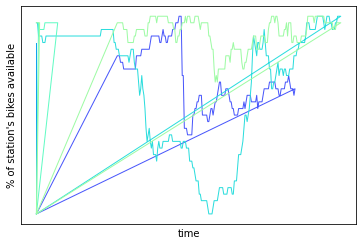

In [3]:
def station_graph(index):
    if MAX_DISPLAYED_DAYS < TOTAL_DAYS:
        colors= cm.rainbow(np.linspace(0, 1, MAX_DISPLAYED_DAYS))
    else:
        colors= cm.rainbow(np.linspace(0, 1, TOTAL_DAYS))

    for (day_i, day), c in zip(enumerate(stations[index].data_days), colors): # use day_i + 1 to access days because day 0 is empty but kept so that the day's date works as an array index too
        if day_i >= MAX_DISPLAYED_DAYS:
            break
        #plt.scatter(station.daily_epoch_time, station.percent_bikes, 1, marker="*", color= c, linewidth=0.0001)
        plt.plot(day.daily_epoch_time, day.percent_bikes, 1, color= c, linewidth=1)
    plt.ylabel('% of station\'s bikes available')
    plt.xlabel('time')
    plt.xticks(())
    plt.yticks(())

    plt.show()

    #plt.scatter(daily_epoch_time, percent_bikes,  color='black')

station_graph(get_station_id('PORTOBELLO ROAD'))

In [4]:
# Approach 01 - Data Prep

time= int((datetime.datetime(2020, 1, 1, 6, 25) - datetime.datetime(2020, 1, 1, 0, 0)).total_seconds() / SECS_IN_5MIN)
station_index_decrement= 1 # this is a varying offset for the indexing of stations that accounts for missing stations that are being ignored
fullness= np.zeros((MAX_TIME - time, MAX_STATION_ID - len(MISSING_STATIONS)), dtype=np.float)
day_of_week= np.zeros((MAX_TIME - time, len(DAYS_OF_WEEK)), dtype=np.int)
#hour_of_day= np.zeros((MAX_TIME - time, 1), dtype=np.float)

for epoch_day_i in range(TOTAL_DAYS):
    for station in stations:
        #print("## STATION")
        if station.index == 1:
            station_index_decrement= 0
        if station.index in MISSING_STATIONS:
            station_index_decrement+= 1
            continue
        block= station.data_days[epoch_day_i].percent_bikes
        block= np.reshape(block, (288, 1))
        x= epoch_day_i * DATAPOINTS_PER_DAY
        y= station.index - station_index_decrement
        fullness[x:x + block.shape[0], y:y + block.shape[1]]= block
        block= np.zeros((DATAPOINTS_PER_DAY, len(DAYS_OF_WEEK)), dtype=np.int)
        day= (epoch_day_i + 2) % len(DAYS_OF_WEEK) # Jan 1st is a wednesday, so need to add 2 to make it so
        for block_i, sub_arr in enumerate(block):
            #print("# block_i")
            block[block_i][day]= 1
        y= 0
        day_of_week[x:x + block.shape[0], y:y + block.shape[1]]= block

